# Decoding (MVPA)

Based on `https://mne.tools/stable/auto_tutorials/machine-learning/50_decoding.html`

## Design philosophy
Decoding (a.k.a. MVPA) in MNE largely follows the machine learning API of the
scikit-learn package.
Each estimator implements ``fit``, ``transform``, ``fit_transform``, and
(optionally) ``inverse_transform`` methods. For more details on this design,
visit [`scikit-learn`](https://scikit-learn.org/stable/). For additional theoretical insights into the decoding
framework in MNE see [`King et al. (2018)`](https://hal.science/hal-01848442).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer

import mne
from mne.datasets import sample
from mne.decoding import (
    GeneralizingEstimator,
    LinearModel,
    Scaler,
    SlidingEstimator,
    Vectorizer,
    cross_val_multiscore,
    get_coef,
)
from mvpa import (
    moving_window_preprocessor, 
    pseudotrial_generator
)

In [2]:
# Reading and preprocessing the raw data
data_path = sample.data_path()
meg_path = data_path / "MEG" / "sample"
raw_fname = meg_path / "sample_audvis_filt-0-40_raw.fif"

# reading raw data from disk
raw = mne.io.read_raw_fif(raw_fname)
raw.pick(picks=["grad", "stim", "eog"])

# The subsequent decoding analyses only capture evoked responses, so we can
# low-pass the MEG data. Usually a value more like 40 Hz would be used,
# but here low-pass at 20 so we can more heavily decimate, and allow
# the example to run faster. The 2 Hz high-pass helps improve CSP.
raw.load_data().filter(2, 20)
events = mne.find_events(raw, "STI 014")

# Set up bad channels
raw.info["bads"] += ["MEG 2443"]  # bads + 2 more

Opening raw data file /imaging/davis/users/ma09/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 249 samples (1.658 s)

319 events found on s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


In [3]:
# Generate epchs

# Define events of interest
# Feel free to uncomment one of the following lines to select only one
event_id = {"Visual/Left": 3, "Visual/Right": 4}  # visual left vs. right
# event_id = {"Auditory/Left": 1, "Auditory/Right": 2}  # auditory left vs. right
# event_id = {"Auditory/Left": 1, "Visual/Left": 3}  # auditory vs. visual left
# event_id = {"Auditory/Right": 2, "Visual/Right": 4}  # auditory vs. visual right

# Define time window of interest
tmin, tmax = -0.200, 0.500

# Read epochs
epochs = mne.Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    proj=True,
    picks=("grad", "eog"),
    baseline=(None, 0.0),
    preload=True,
    reject=dict(grad=4000e-13, eog=150e-6),
    decim=2,
    verbose="error",
)
epochs.pick(picks="meg", exclude="bads")  # remove stim and EOG
del raw

In [4]:
# Extracting MEG data and target labels for MVPA
X = epochs.get_data(copy=False)  # MEG signals: n_epochs, n_meg_channels, n_times
y = epochs.events[:, 2]  # target

In [5]:
np.unique(y, return_counts=True)

(array([3, 4]), array([67, 56]))

## Transformation classes

### Scaler
The [`mne.decoding.Scaler`](https://mne.tools/stable/generated/mne.decoding.Scaler.html#mne.decoding.Scaler) will standardize the data based on channel
scales. In the simplest modes ``scalings=None`` or ``scalings=dict(...)``,
each data channel type (e.g., mag, grad, eeg) is treated separately and
scaled by a constant. This is the approach used by e.g.,
[`mne.compute_covariance`](https://mne.tools/stable/generated/mne.compute_covariance.html#mne.compute_covariance) to standardize channel scales.

If ``scalings='mean'`` or ``scalings='median'``, each channel is scaled using
empirical measures. Each channel is scaled independently by the mean and
standand deviation, or median and interquartile range, respectively, across
all epochs and time points during [`mne.decoding.Scaler.fit`](https://mne.tools/stable/generated/mne.decoding.Scaler.html#mne.decoding.Scaler.fit)
(during training). The [`mne.decoding.Scaler.transform`](https://mne.tools/stable/generated/mne.decoding.Scaler.html#mne.decoding.Scaler.transform) method is
called to transform data (training or test set) by scaling all time points
and epochs on a channel-by-channel basis. To perform both the ``fit`` and
``transform`` operations in a single call, the
[`mne.decoding.Scaler.fit_transform`](https://mne.tools/stable/generated/mne.decoding.Scaler.html#mne.decoding.Scaler.fit_transform) method may be used. To invert the
transform, [`mne.decoding.Scaler.inverse_transform`](https://mne.tools/stable/generated/mne.decoding.Scaler.html#mne.decoding.Scaler.inverse_transform) can be used. For
``scalings='median'``, [scikit-learn](https://scikit-learn.org/stable/) version 0.17+ is required.

<div class="alert alert-info"><h4>Note</h4><p>Using this class is different from directly applying
          `sklearn.preprocessing.StandardScaler` or
          `sklearn.preprocessing.RobustScaler` offered by
          scikit-learn. These scale each *classification feature*, e.g.
          each time point for each channel, with mean and standard
          deviation computed across epochs, whereas
          `mne.decoding.Scaler` scales each *channel* using mean and
          standard deviation computed across all of its time points
          and epochs.</p></div>

### Vectorizer
Scikit-learn API provides functionality to chain transformers and estimators
by using [`sklearn.pipeline.Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline). We can construct decoding
pipelines and perform cross-validation and grid-search. However scikit-learn
transformers and estimators generally expect 2D data
(n_samples * n_features), whereas MNE transformers typically output data
with a higher dimensionality
(e.g. n_samples * n_channels * n_frequencies * n_times). A Vectorizer
therefore needs to be applied between the MNE and the scikit-learn steps
like:



In [6]:
# Uses all MEG sensors and time points as separate classification
# features, so the resulting filters used are spatio-temporal
clf = make_pipeline(
    Scaler(epochs.info),
    Vectorizer(),
    LogisticRegression(solver="liblinear"),  # liblinear is faster than lbfgs
)

scores = cross_val_multiscore(clf, X, y, cv=5, n_jobs=None)

# Mean scores across cross-validation splits
score = np.mean(scores, axis=0)
print(f"Spatio-temporal: {100 * score:0.1f}%")

Spatio-temporal: 98.4%


## Decoding over time

This strategy consists in fitting a multivariate predictive model on each
time instant and evaluating its performance at the same instant on new
epochs. The [`mne.decoding.SlidingEstimator`](https://mne.tools/stable/generated/mne.decoding.SlidingEstimator.html#mne.decoding.SlidingEstimator) will take as input a
pair of features $X$ and targets $y$, where $X$ has
more than 2 dimensions. For decoding over time the data $X$
is the epochs data of shape n_epochs × n_channels × n_times. As the
last dimension of $X$ is the time, an estimator will be fit
on every time instant.

This approach is analogous to SlidingEstimator-based approaches in fMRI,
where here we are interested in when one can discriminate experimental
conditions and therefore figure out when the effect of interest happens.

When working with linear models as estimators, this approach boils
down to estimating a discriminative spatial filter for each time instant.

### Temporal decoding

In [7]:
# Utility function for plotting the decoding scores
def plot_temporal_decoding(scores, times=epochs.times):
    fig, ax = plt.subplots()
    ax.plot(times, scores, label="score")
    ax.axhline(0.5, color="k", linestyle="--", label="chance")
    ax.set_xlabel("Times")
    ax.set_ylabel("AUC")  # Area Under the Curve
    ax.legend()
    ax.axvline(0.0, color="k", linestyle="-")
    ax.set_title("Sensor space decoding")
    plt.show()

  0%|          | Fitting SlidingEstimator : 0/53 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/53 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/53 [00:00<?,       ?it/s]

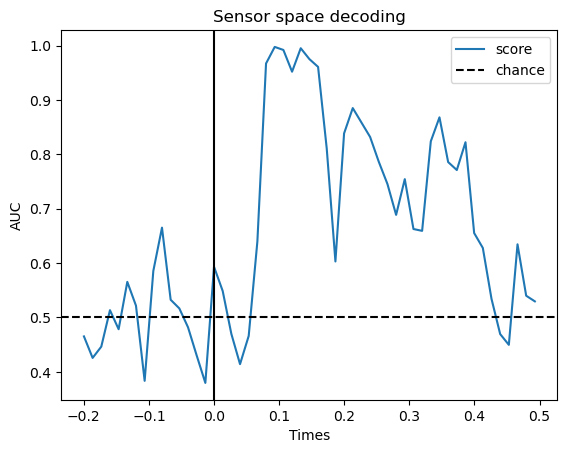

In [8]:
# Define the pipeline consisting of a scaler and a classifier. 
# Here we can use the StandardScaler as the SlidingEstimator will
# make sure that the pipeline gets fed with a single time point at once.
# We'll use a Logistic Regression for a binary classification as machine
# learning model.
clf = make_pipeline(StandardScaler(), LogisticRegression(solver="liblinear"))

# Wrap the pipeline with a SlidingEstimator
time_decod = SlidingEstimator(clf, n_jobs=None, scoring="roc_auc", verbose=True)

# Compute the cross-validation scores, here we use cv=3 just for speed
scores = cross_val_multiscore(time_decod, X, y, cv=3, n_jobs=None)

# Mean scores across cross-validation splits
scores = np.mean(scores, axis=0)

# Plot
plot_temporal_decoding(scores)

You can retrieve the spatial filters and spatial patterns if you explicitly
use a LinearModel



  0%|          | Fitting SlidingEstimator : 0/53 [00:00<?,       ?it/s]

No projector specified for this dataset. Please consider the method self.add_proj.


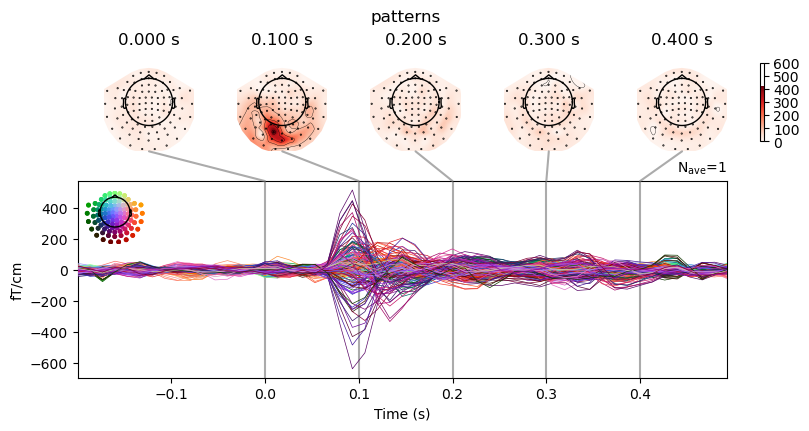

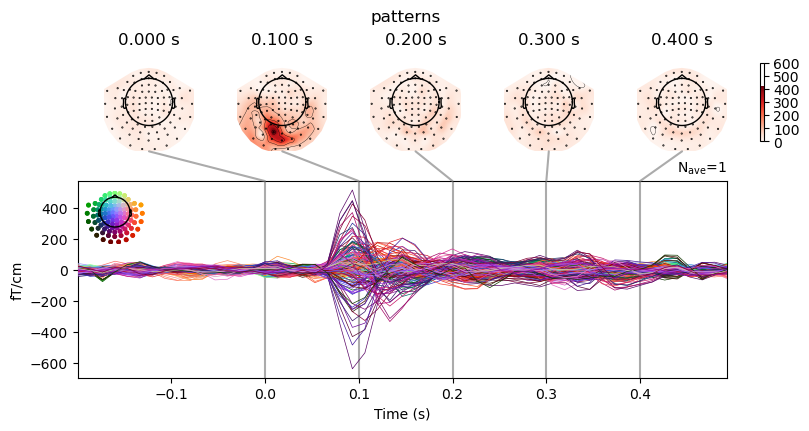

In [9]:
clf = make_pipeline(
    StandardScaler(), LinearModel(LogisticRegression(solver="liblinear"))
)
time_decod = SlidingEstimator(clf, n_jobs=None, scoring="roc_auc", verbose=True)
time_decod.fit(X, y)

coef = get_coef(time_decod, "patterns_", inverse_transform=True)
evoked_time_gen = mne.EvokedArray(coef, epochs.info, tmin=epochs.times[0])
joint_kwargs = dict(ts_args=dict(time_unit="s"), topomap_args=dict(time_unit="s"))
evoked_time_gen.plot_joint(
    times=np.arange(0.0, 0.500, 0.100), title="patterns", **joint_kwargs
)

### Improving signal-to-noise ratio
#### Moving temporal window decoding

  0%|          | Fitting SlidingEstimator : 0/49 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/49 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/49 [00:00<?,       ?it/s]

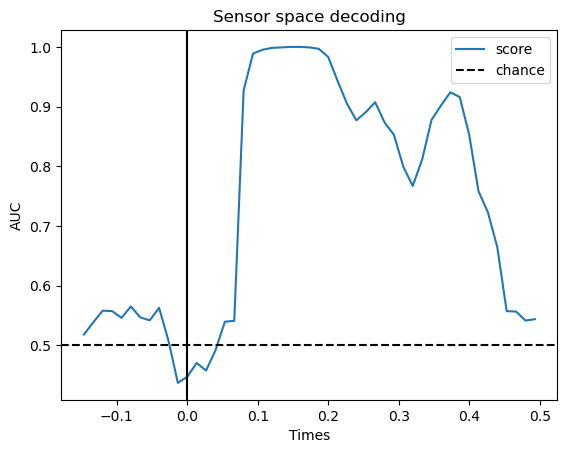

In [10]:
# We will train the classifier on all left visual vs auditory trials on MEG
mwin_size = 5 # you may want to try different values e.g. 2, 5, 10, 20
preprocessor = moving_window_preprocessor(moving_window_size=mwin_size)

time_decod = SlidingEstimator(LogisticRegression(solver="liblinear"),
                              n_jobs=None,
                              scoring="roc_auc",
                              verbose=True)
# Compute the cross-validated scores
# We apply the preprocessor to the data before they are passed to the
# SlidingEstimator to ensure that the moving window is applied to the
# preprocessed data before it is passed to the classifier a singe time point
# at a time.
scores = cross_val_multiscore(
    estimator=time_decod,
    X=preprocessor.fit_transform(X),
    y=y,
    cv=3,
    n_jobs=None)

# Mean scores across cross-validation splits
scores = np.mean(scores, axis=0)

# Plot
plot_temporal_decoding(scores, times=epochs.times[mwin_size-1:])

#### Temporal decoding with pseudotrials
Another way of increasing signal-to-noise ratio is to create pseudotrials by
averaging over trials ([Grootswagers et al. (2017)](https://tijl.github.io/tijl-grootswagers-pdf/Grootswagers_et_al_-_2017_-_Decoding_Dynamic_Brain_Patterns_from_Evoked_Respon.pdf)). 
This is particularly useful when the number of repetitions per condition is 
relatively high. 

The idea is for each condition to randomly partition the 
trials into predefined number (`n_pseudo`) of roughly equal sets and average over 
them. Thereby creating `n_pseudo` pseudotrials for each condition. Each pseudotrial
is based on roughly `n_trials_per_condition`/`n_pseudo` trials. Thereby increasing
the signal-to-noise ratio. 

The optimal number of trials to be averaged over in a pseudotrial will
depend on the signal-to-noise ratio and the number of trials available
(see Figure 8. in [Grootswagers et al. (2017)](https://tijl.github.io/tijl-grootswagers-pdf/Grootswagers_et_al_-_2017_-_Decoding_Dynamic_Brain_Patterns_from_Evoked_Respon.pdf)): 
more trials averaged over in each pseudotrial increases signal-to-noise, but it 
decreases the number of examples (pseudotrials) available for the decoding 
algorithm. This can be determined empirically on a subset of the data and fixed
for the final analysis. 

Because the random partitioning of trials into pseudotrials can lead to 
different results, it is recommended to repeat the procedure multiple times
and average the results.

Repetition 1/10


  0%|          | Fitting SlidingEstimator : 0/53 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/53 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/53 [00:00<?,       ?it/s]

Repetition 2/10


  0%|          | Fitting SlidingEstimator : 0/53 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/53 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/53 [00:00<?,       ?it/s]

Repetition 3/10


  0%|          | Fitting SlidingEstimator : 0/53 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/53 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/53 [00:00<?,       ?it/s]

Repetition 4/10


  0%|          | Fitting SlidingEstimator : 0/53 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/53 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/53 [00:00<?,       ?it/s]

Repetition 5/10


  0%|          | Fitting SlidingEstimator : 0/53 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/53 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/53 [00:00<?,       ?it/s]

Repetition 6/10


  0%|          | Fitting SlidingEstimator : 0/53 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/53 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/53 [00:00<?,       ?it/s]

Repetition 7/10


  0%|          | Fitting SlidingEstimator : 0/53 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/53 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/53 [00:00<?,       ?it/s]

Repetition 8/10


  0%|          | Fitting SlidingEstimator : 0/53 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/53 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/53 [00:00<?,       ?it/s]

Repetition 9/10


  0%|          | Fitting SlidingEstimator : 0/53 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/53 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/53 [00:00<?,       ?it/s]

Repetition 10/10


  0%|          | Fitting SlidingEstimator : 0/53 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/53 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/53 [00:00<?,       ?it/s]

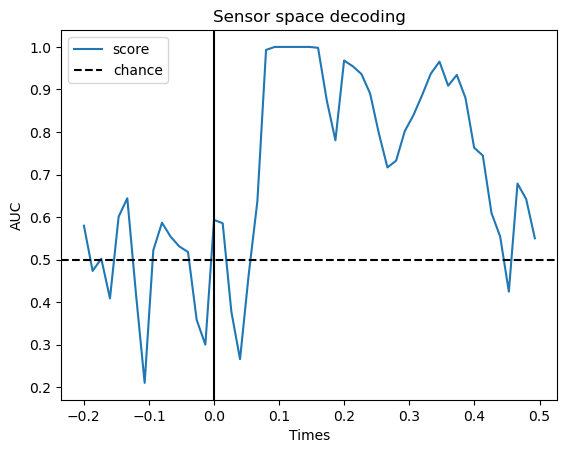

In [11]:
# Number of trials to average for each pseudotrial
n_trials_to_average=5
# Number of repetitions of the whole procedure
# The more repetitions, the more stable the results
n_repetitions = 10 # you may want to try different values e.g. 5, 10, 20

# Define the pipeline consisting of a scaler and a classifier. 
clf = make_pipeline(StandardScaler(), LogisticRegression(solver="liblinear"))

# Wrap the pipeline with a SlidingEstimator
time_decod = SlidingEstimator(clf, n_jobs=None, scoring="roc_auc", verbose=True)

scores_list = []
for i in range(n_repetitions):
    print(f"Repetition {i+1}/{n_repetitions}")
    
    # Sample new pseudotrials
    X_avg, y_avg = pseudotrial_generator(X, y, n_trials_to_average=n_trials_to_average)

    # Compute the cross-validation scores, here we use cv=3 just for speed
    temp_scores = cross_val_multiscore(time_decod, X_avg, y_avg, cv=3, n_jobs=None)

    # Mean scores across cross-validation splits
    scores_list.append(np.mean(temp_scores, axis=0))

# Mean scores across repetitions
scores = np.mean(np.stack(scores_list, axis=-1), axis=-1)

# Plot
plot_temporal_decoding(scores)

#### Combining moving temporal window decoding and pseudotrials

Repetition 1/10


  0%|          | Fitting SlidingEstimator : 0/49 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/49 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/49 [00:00<?,       ?it/s]

Repetition 2/10


  0%|          | Fitting SlidingEstimator : 0/49 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/49 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/49 [00:00<?,       ?it/s]

Repetition 3/10


  0%|          | Fitting SlidingEstimator : 0/49 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/49 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/49 [00:00<?,       ?it/s]

Repetition 4/10


  0%|          | Fitting SlidingEstimator : 0/49 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/49 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/49 [00:00<?,       ?it/s]

Repetition 5/10


  0%|          | Fitting SlidingEstimator : 0/49 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/49 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/49 [00:00<?,       ?it/s]

Repetition 6/10


  0%|          | Fitting SlidingEstimator : 0/49 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/49 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/49 [00:00<?,       ?it/s]

Repetition 7/10


  0%|          | Fitting SlidingEstimator : 0/49 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/49 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/49 [00:00<?,       ?it/s]

Repetition 8/10


  0%|          | Fitting SlidingEstimator : 0/49 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/49 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/49 [00:00<?,       ?it/s]

Repetition 9/10


  0%|          | Fitting SlidingEstimator : 0/49 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/49 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/49 [00:00<?,       ?it/s]

Repetition 10/10


  0%|          | Fitting SlidingEstimator : 0/49 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/49 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/49 [00:00<?,       ?it/s]

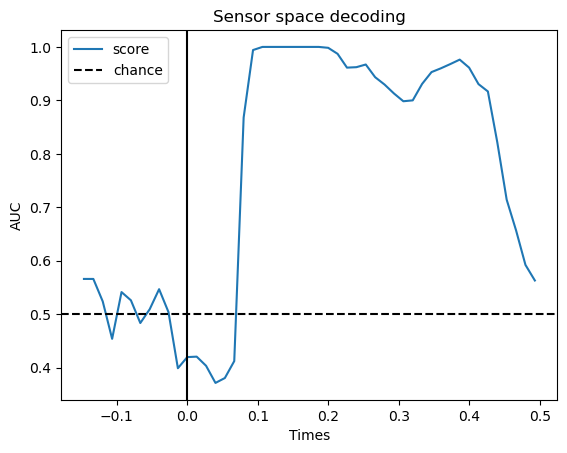

In [12]:
# Number of trials to average for each pseudotrial
n_trials_to_average=5

# Number of repetitions of the whole procedure
n_repetitions = 10

# Define the pipeline consisting of a scaler and a classifier. 
clf = make_pipeline(StandardScaler(), LogisticRegression(solver="liblinear"))

# We will train the classifier on all left visual vs auditory trials on MEG
mwin_size = 5
preprocessor = moving_window_preprocessor(moving_window_size=mwin_size)

# Wrap the pipeline with a SlidingEstimator
time_decod = SlidingEstimator(clf, n_jobs=None, scoring="roc_auc", verbose=True)

scores_list = []
for i in range(n_repetitions):
    print(f"Repetition {i+1}/{n_repetitions}")
    
    # Sample new pseudotrials
    X_avg, y_avg = pseudotrial_generator(X, y, n_trials_to_average=n_trials_to_average)

    # Compute the cross-validation scores, here we use cv=3 just for speed
    temp_scores = cross_val_multiscore(
        estimator=time_decod,
        X=preprocessor.fit_transform(X_avg),
        y=y_avg,
        cv=3,
        n_jobs=None)

    # Mean scores across cross-validation splits
    scores_list.append(np.mean(temp_scores, axis=0))

# Mean scores across repetitions
scores = np.mean(np.stack(scores_list, axis=-1), axis=-1)

# Plot
plot_temporal_decoding(scores, times=epochs.times[mwin_size-1:])

### Temporal generalization

Temporal generalization is an extension of the decoding over time approach.
It consists in evaluating whether the model estimated at a particular
time instant accurately predicts any other time instant. It is analogous to
transferring a trained model to a distinct learning problem, where the
problems correspond to decoding the patterns of brain activity recorded at
distinct time instants.

The object to for Temporal generalization is
[`mne.decoding.GeneralizingEstimator`](https://mne.tools/stable/generated/mne.decoding.GeneralizingEstimator.html#mne.decoding.GeneralizingEstimator). It expects as input $X$
and $y$ (similarly to [`~mne.decoding.SlidingEstimator`](https://mne.tools/stable/generated/mne.decoding.SlidingEstimator.html#mne.decoding.SlidingEstimator)) but
generates predictions from each model for all time instants. The class
[`~mne.decoding.GeneralizingEstimator`](https://mne.tools/stable/generated/mne.decoding.GeneralizingEstimator.html#mne.decoding.GeneralizingEstimator) is generic and will treat the
last dimension as the one to be used for generalization testing. For
convenience, here, we refer to it as different tasks. If $X$
corresponds to epochs data then the last dimension is time.

This runs the analysis used in [`King et al. (2018)`](https://hal.science/hal-01848442)
and further detailed in [`King & Dehaene (2014)`](https://europepmc.org/backend/ptpmcrender.fcgi?accid=PMC5635958&blobtype=pdf):



  0%|          | Fitting GeneralizingEstimator : 0/53 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/2809 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/53 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/2809 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/53 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/2809 [00:00<?,       ?it/s]

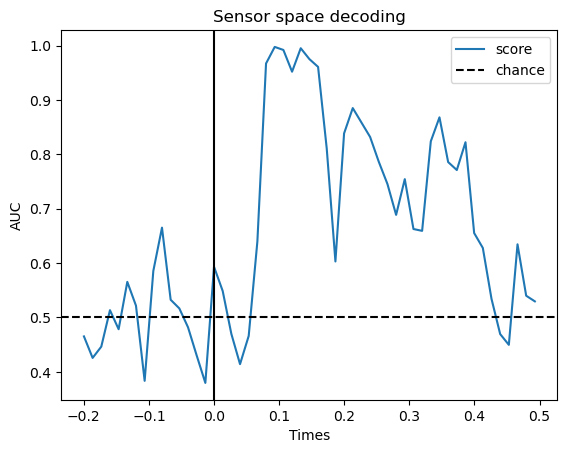

In [13]:
# define the Temporal generalization object
time_gen = GeneralizingEstimator(clf, n_jobs=None, scoring="roc_auc", verbose=True)

# again, cv=3 just for speed
scores = cross_val_multiscore(time_gen, X, y, cv=3, n_jobs=None)

# Mean scores across cross-validation splits
scores = np.mean(scores, axis=0)

# Plot the diagonal (it's exactly the same as the time-by-time decoding above)
plot_temporal_decoding(np.diag(scores))
# fig, ax = plt.subplots()
# ax.plot(epochs.times, np.diag(scores), label="score")
# ax.axhline(0.5, color="k", linestyle="--", label="chance")
# ax.set_xlabel("Times")
# ax.set_ylabel("AUC")
# ax.legend()
# ax.axvline(0.0, color="k", linestyle="-")
# ax.set_title("Decoding MEG sensors over time")

Plot the full (generalization) matrix:



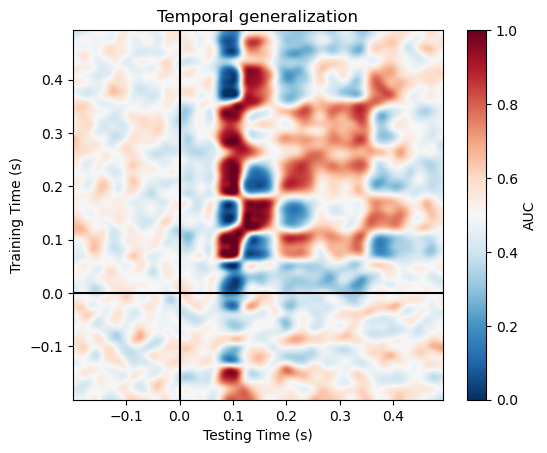

In [14]:
fig, ax = plt.subplots(1, 1)
im = ax.imshow(
    scores,
    interpolation="lanczos",
    origin="lower",
    cmap="RdBu_r",
    extent=epochs.times[[0, -1, 0, -1]],
    vmin=0.0,
    vmax=1.0,
)
ax.set_xlabel("Testing Time (s)")
ax.set_ylabel("Training Time (s)")
ax.set_title("Temporal generalization")
ax.axvline(0, color="k")
ax.axhline(0, color="k")
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("AUC")
plt.show()

The temporal generalization approach can be combined with moving temporal
window decoding and pseudotrials. However, these combined approaches can be
computationally expensive, hence we will not demonstrate them here.